<a href="https://colab.research.google.com/github/ananya2707/SAR-Image-Colorization/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Urban Density Analysis using SAR Imagery

This notebook demonstrates the analysis of urban density using Synthetic Aperture Radar (SAR) imagery. The workflow includes:

1. **Data Preprocessing**:
    - Loading SAR images.
    - Applying log scaling and normalization.
    - Visualizing the normalized backscatter.

2. **Feature Extraction**:
    - Using filters like bilateral, Gabor, and Sobel to extract features.
    - Computing gradient magnitudes and texture information.

3. **Segmentation**:
    - Applying KMeans clustering for initial segmentation.
    - Using local thresholding and watershed segmentation for refined results.

4. **Classification**:
    - Classifying regions into urban, suburban, and rural classes based on intensity and area.
    - Visualizing classified regions with color-coded maps.

5. **Comparison**:
    - Comparing urban density across different regions using histograms and bar charts.

6. **Visualization**:
    - Displaying original images, segmentation masks, and colorized outputs.
    - Plotting area percentages for each class.

This analysis provides insights into urbanization patterns and helps in understanding land use and planning.
```

In [ ]:
#import required libraries
import cv2
import numpy as np
import pandas as pd
import rasterio
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from scipy.stats import entropy
from rasterio.plot import show
from sklearn.cluster import KMeans
from skimage.color import rgb2gray
from skimage.filters import sobel
from skimage.filters import gabor
from skimage.segmentation import watershed
from skimage.filters import threshold_local
from skimage.measure import regionprops, label
from skimage import filters, segmentation, color
from skimage.restoration import denoise_bilateral

### Image-1: New Delhi, India

This section focuses on analyzing the urban density of New Delhi, India using SAR imagery.

In [ ]:
# Read the image using rasterio
fp = r'snap\subset_1_of_S1A_IW_GRDH_1SDV_2025_Cal_TF_TNR_TC.tif'
img = rasterio.open(fp)
image_array = img.read()
print(image_array.shape)

(2, 1234, 1565)


C:\Users\yanan\AppData\Local\Temp\ipykernel_13996\538913505.py:6: RuntimeWarning: divide by zero encountered in log10
  band_VV = np.where(band_VV > 0, 10 * np.log10(band_VV), 0)


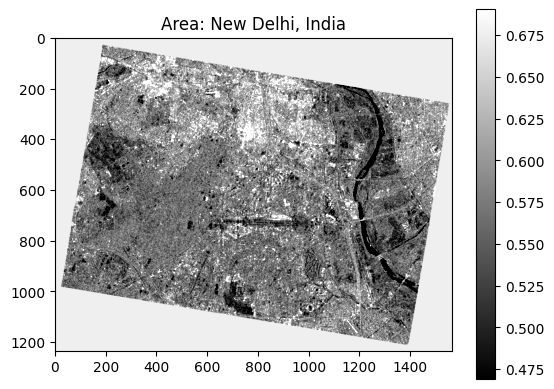

In [ ]:
# Read the image data
band_VV = img.read(2)
band_VV = band_VV.astype(np.float32)

# Apply log scaling to the image data
band_VV = np.where(band_VV > 0, 10 * np.log10(band_VV), 0)

# Normalize the image data to the range [0, 1]
band_VV = (band_VV - np.min(band_VV)) / (np.max(band_VV) - np.min(band_VV))

# Clip values for better visualization
vmin, vmax = np.percentile(band_VV, [2, 98])
plt.imshow(band_VV, cmap='gray', vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title('Area: New Delhi, India')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


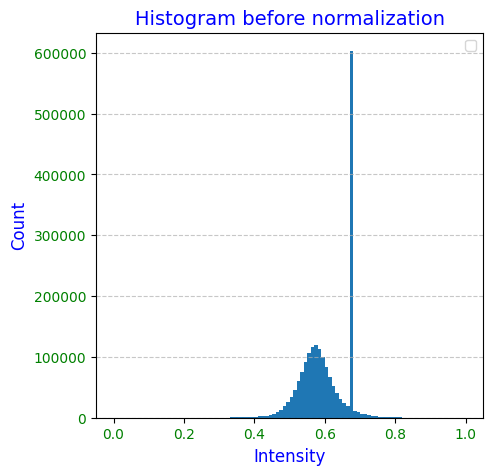

In [ ]:
# HISTOGRAM
plt.figure(figsize=(5, 5))
plt.hist(band_VV.ravel(), bins=100)
plt.title("Histogram before normalization", fontsize=14, color='blue')
plt.xlabel("Intensity", fontsize=12, color='blue')
plt.ylabel("Count", fontsize=12, color='blue')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(fontsize=10, color='green')
plt.yticks(fontsize=10, color='green')
plt.legend()
plt.show()

### Filtering

This section applies various filtering techniques to enhance the features of the SAR imagery. Filters such as bilateral and Gabor are used to reduce noise, extract texture, and highlight linear structures like roads and building edges. These filtered outputs are crucial for subsequent segmentation and classification steps.

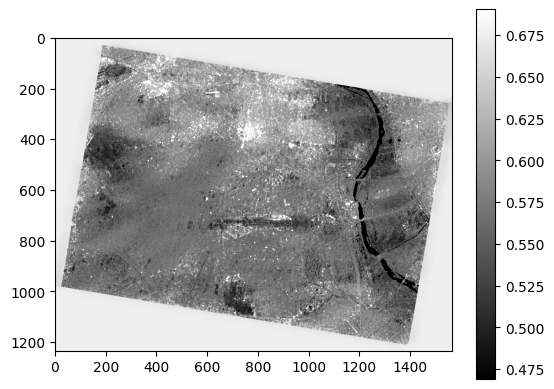

In [ ]:
# bilateral filter
band_filtered = denoise_bilateral(band_VV, sigma_color=0.05, sigma_spatial=15)
plt.imshow(band_filtered, cmap='gray', vmin=vmin, vmax=vmax)
plt.colorbar()

In [ ]:
# Gabor filter to pick out linear structures (roads, building walls, etc)
real, imag = gabor(band_filtered, frequency=0.2)
texture = np.sqrt(real**2 + imag**2)

### KMeans Classification

In this section, KMeans clustering is applied to segment the SAR imagery into distinct regions based on intensity and texture features. The clustering algorithm groups pixels into predefined clusters, representing different urban density levels. This step is crucial for identifying patterns and structures in the urban landscape, which will be further refined in subsequent segmentation and classification steps.

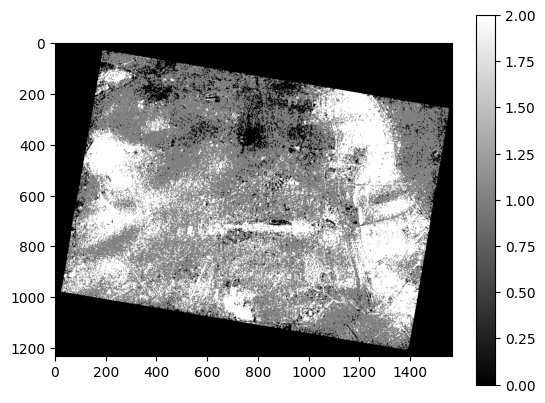

In [ ]:
# KMeans clustering to segment the image into 3 clusters
X = np.stack([band_filtered.ravel(), texture.ravel()], axis=1)
labels_k3 = KMeans(n_clusters=3).fit_predict(X).reshape(band_filtered.shape)
plt.imshow(labels_k3, cmap='gray', vmin=0, vmax=2)
plt.colorbar()

### Visualization of KMeans Clustering Results

This section visualizes the results of KMeans clustering applied to the SAR imagery. The clustering groups pixels into three distinct clusters based on intensity and texture features, representing different urban density levels. The output is displayed as a grayscale image, where each cluster is assigned a unique intensity value.

In [ ]:
# Local thresholding to segment the image
th_local = threshold_local(band_filtered, block_size=101, offset=0.01)
markers = np.zeros_like(band_filtered, int)
markers[band_filtered <  th_local*0.8] = 1
markers[band_filtered >  th_local*1.2] = 2
print("Threshold:", th_local.mean())

Threshold: 0.5956708


### Histogram of Filtered Backscatter

This section visualizes the histogram of the filtered backscatter values after applying normalization and filtering. The histogram provides insights into the distribution of intensity values, which is crucial for understanding the characteristics of the SAR imagery and for subsequent segmentation and classification steps.

In [ ]:
# Percentiles for the histogram
# 5% = rural, 50% = suburban, 95% = urban
p5, p50, p95 = np.percentile(band_filtered, [5, 50, 95])

print(f"Seeds at: 25%={p5:.3f}, 50%={p50:.3f}, 95%={p95:.3f}")

# Create markers for watershed segmentation
markers[band_filtered <= p5]                       = 1   # definitely ruralral
markers[(band_filtered >  p5)  & (band_filtered <= p50)]  = 2   # suburban
markers[(band_filtered >  p50) & (band_filtered <= p95)]  = 3   # urban
markers[band_filtered >   p95]                      = 4   # very dense urban urban

Seeds at: 25%=0.528, 50%=0.591, 95%=0.676


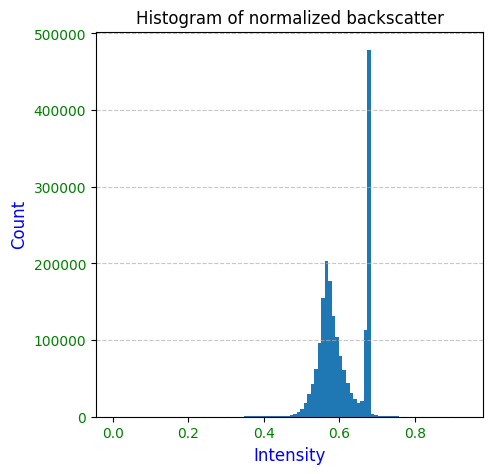

In [ ]:
# HISTOGRAM
plt.figure(figsize=(5, 5))
plt.hist(band_filtered.ravel(), bins=100)
plt.title("Histogram of normalized backscatter")
plt.xlabel("Intensity", fontsize=12, color='blue')
plt.ylabel("Count", fontsize=12, color='blue')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(fontsize=10, color='green')
plt.yticks(fontsize=10, color='green')
plt.show()

### Watershed Segmentation with Tuned Seeds

This section applies the watershed algorithm to segment the SAR imagery into distinct regions using the gradient magnitude and predefined markers. The watershed algorithm refines the segmentation by considering the gradient information, resulting in more accurate boundaries between regions. The output is visualized as a color-coded segmentation map.

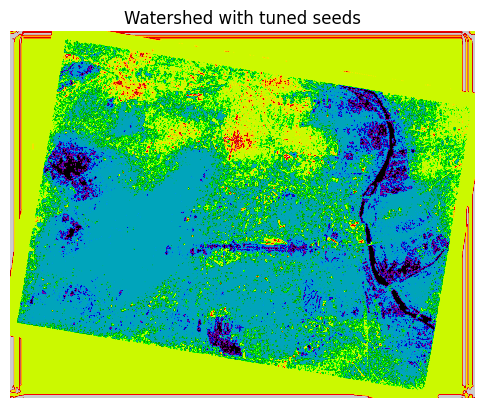

In [ ]:
# Sobel filter to compute the gradient magnitude
elev = sobel(band_filtered)
labels_k3 = watershed(elev, markers)
plt.figure(figsize=(6,6))
plt.imshow(labels_k3, cmap='nipy_spectral')
plt.axis('off')
plt.title("Watershed with tuned seeds")
plt.show()

### Classification of Regions

This section classifies the segmented regions into urban, suburban, and rural classes based on their mean intensity and area. The classification is performed using predefined thresholds, and the results are visualized as a color-coded segmentation map. Additionally, the mean area and mean intensity of the classified regions are calculated and displayed.

Mean area of classified regions: 482802.5
Mean intensity of classified regions: 0.5990017056465149


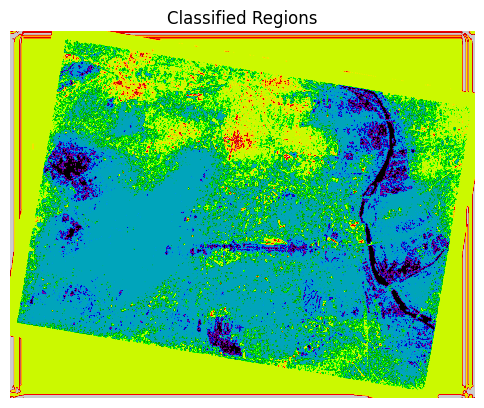

In [ ]:
# Classify the regions based on mean intensity and area
records = []
for reg in regionprops(labels_k3, intensity_image=band_filtered):
    # Calculate mean intensity and area for each region
    records.append({
        'label': reg.label,
        'mean_intensity': reg.mean_intensity,
        'area': reg.area
    })
df = pd.DataFrame(records)
# Define thresholds heuristically:
df['class'] = pd.cut(df['mean_intensity'],
                    bins=[-np.inf, (p5+p50)/2, (p50+p95)/2, np.inf],
                    labels=['rural','suburban','urban'])


mean_area = df['area'].mean()
print(f'Mean area of classified regions: {mean_area}')


mean_intensity = df['mean_intensity'].mean()
print(f'Mean intensity of classified regions: {mean_intensity}')



# Display the classified regions
plt.figure(figsize=(6, 6))
plt.imshow(labels_k3, cmap='nipy_spectral')
plt.title('Classified Regions')
plt.axis('off')
plt.show()

### Visualization of Classified Regions

This section visualizes the classified regions by assigning distinct RGB colors to each class (urban, suburban, and rural). The RGB image provides an intuitive representation of the urban density levels, making it easier to interpret the classification results. The color mapping is as follows:

- **Urban**: Red
- **Suburban**: Green
- **Rural**: Yellow

The output is displayed as a colorized image, where each pixel is assigned a color based on its classification.

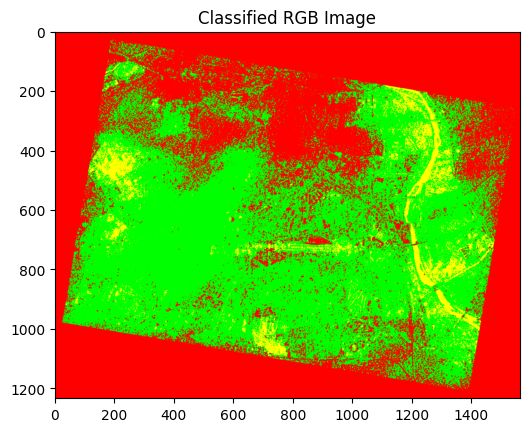

In [ ]:
# Initialize RGB canvas
h, w = band_VV.shape
rgb = np.zeros((h, w, 3), dtype=np.uint8)
# Color map with RGB values
color_dict = {'urban': [255, 0, 0], 'suburban': [0, 255, 0], 'rural': [255, 255, 0]}

for _, row in df.iterrows():
    # Create a mask for the current label
    mask = labels_k3 == row['label']
    rgb[mask] = color_dict[row['class']]
# Display the RGB image
plt.figure(figsize=(6,6))
plt.imshow(rgb)
plt.title('Classified RGB Image')
plt.show()

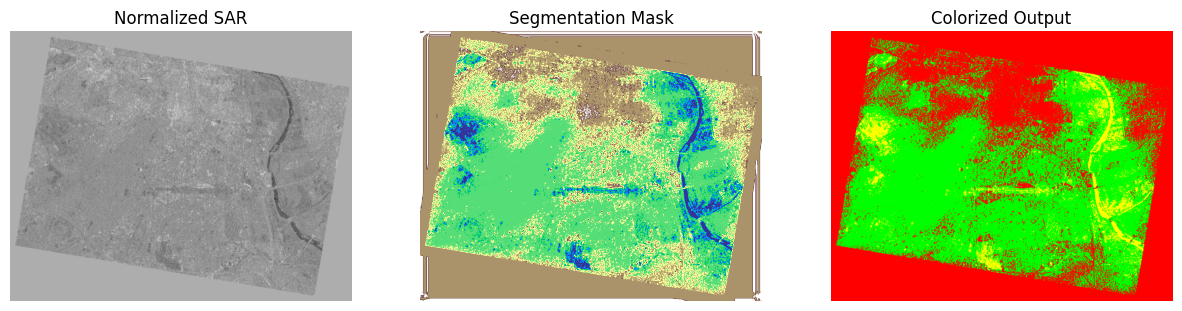

In [ ]:
# Plot the original image, segmentation mask, and colorized output
fig, axes = plt.subplots(1,3, figsize=(15,5))
axes[0].imshow(band_VV, cmap='gray'); axes[0].set_title('Normalized SAR')
axes[1].imshow(labels_k3, cmap='terrain'); axes[1].set_title('Segmentation Mask')
axes[2].imshow(rgb); axes[2].set_title('Colorized Output')
for ax in axes: ax.axis('off')
plt.show()

### Area Percentage of Each Class

This section calculates the area percentage of each urban density class (rural, suburban, and urban) based on the classified regions. The results are displayed as a percentage of the total scene area, providing insights into the distribution of urban density levels within the analyzed region.

In [ ]:
#Area percentage of each class
total = h*w
area_pct = df.groupby('class')['area'].sum() / total * 100
print(area_pct)

class
rural        5.000026
suburban    44.999974
urban       50.000000
Name: area, dtype: float64


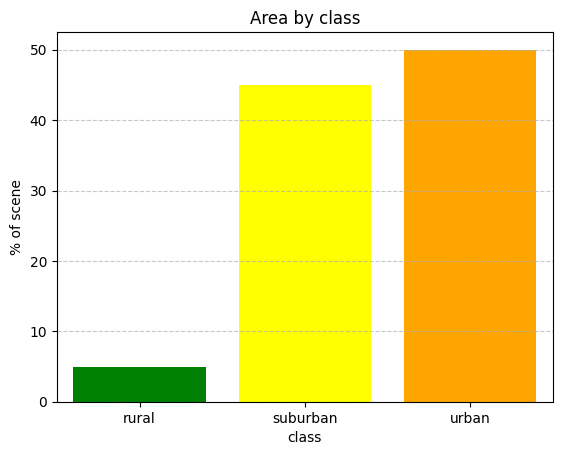

In [ ]:
# Plot the area percentages as a bar chart
area_pct.plot.bar()
plt.bar(area_pct.index, area_pct, color=['green', 'yellow', 'orange'])

# Add labels and title to the plot
plt.ylabel('% of scene')
plt.title('Area by class')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Image-2: Outskirts of New Delhi, India

This section focuses on analyzing the urban density of the outskirts of New Delhi, India using SAR imagery.

In [ ]:
# Upload the new image for comparison
img2 = 'snap\subset_1_of_S1A_IW_GRDH_1SDV_20250327T005226_2025_Cal_TF_tnr_Spk_TC.tif'
with rasterio.open(img2) as img:
    band_vv_new = img.read(1)  # Single band image

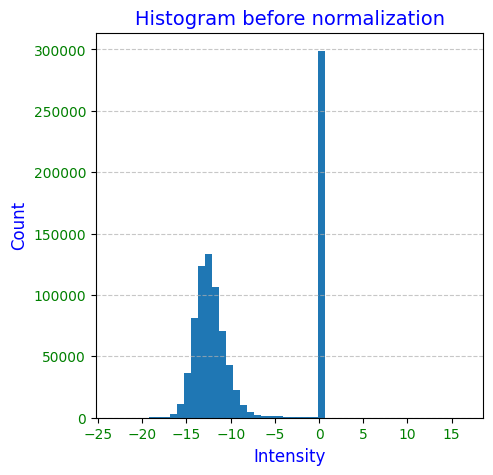

In [ ]:
# HISTOGRAM
plt.figure(figsize=(5, 5))
plt.hist(band_vv_new.ravel(), bins=50)
plt.title("Histogram before normalization", fontsize=14, color='blue')
plt.xlabel("Intensity", fontsize=12, color='blue')
plt.ylabel("Count", fontsize=12, color='blue')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(fontsize=10, color='green')
plt.yticks(fontsize=10, color='green')
plt.show()

C:\Users\yanan\AppData\Local\Temp\ipykernel_13996\4271532958.py:2: RuntimeWarning: divide by zero encountered in log10
  band_vv_new = np.where(band_vv_new > 0, 10 * np.log10(band_vv_new), 0)


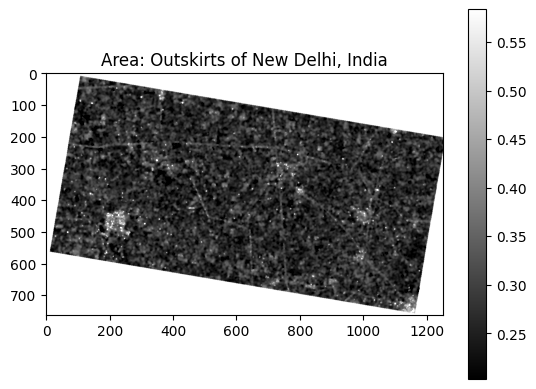

In [ ]:
# Apply log scaling to the image data
band_vv_new = np.where(band_vv_new > 0, 10 * np.log10(band_vv_new), 0)

# Normalize the image data to the range [0, 1]
band_VV_norm = (band_vv_new - np.min(band_vv_new)) / (np.max(band_vv_new) - np.min(band_vv_new))

# Clip values for better visualization
vmin1, vmax1 = np.percentile(band_VV_norm, [2, 98])
plt.imshow(band_VV_norm, cmap='gray', vmin=vmin1, vmax=vmax1)
plt.colorbar()
plt.title('Area: Outskirts of New Delhi, India')
plt.show()

In [ ]:
# Log Scaling
log_scaled = np.log1p(band_VV_norm)

# Normalization
norm = (log_scaled - np.min(log_scaled)) / (np.max(log_scaled) - np.min(log_scaled))

# Denoising using bilateral filter
norm_uint8 = np.uint8(norm * 255)
denoised = cv2.bilateralFilter(norm_uint8, d=9, sigmaColor=75, sigmaSpace=75)

# Flatten for clustering
X = denoised.reshape(-1, 1)

In [ ]:
# cluster using KMeans
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
labels = kmeans.fit_predict(X)
labels_img = labels.reshape(denoised.shape)

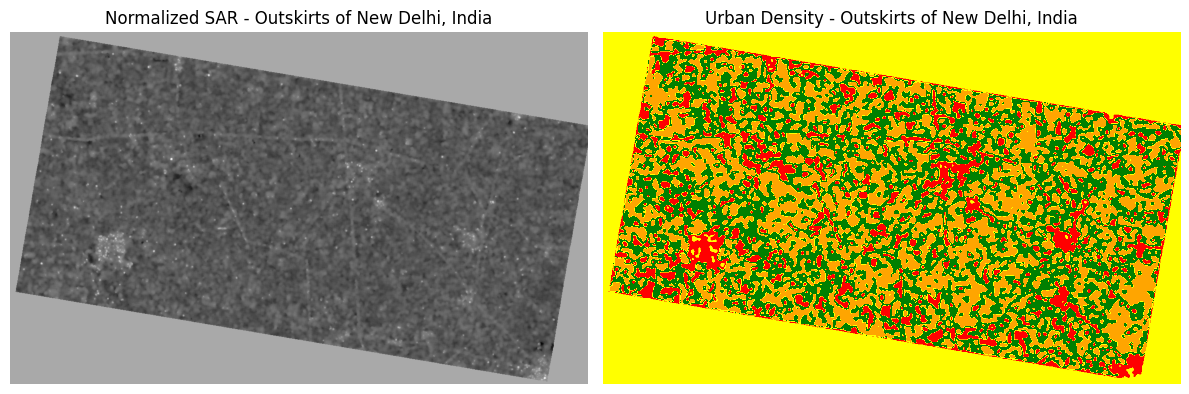

In [ ]:
# Color map for urban density levels
from matplotlib.colors import ListedColormap
cmap = ListedColormap(['green', 'yellow', 'orange', 'red'])

# Define region_name and show_plot if not already defined
region_name = "Outskirts of New Delhi, India"
show_plot = True

if show_plot:
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(norm, cmap='gray')
    plt.title(f"Normalized SAR - {region_name}")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(labels_img, cmap=cmap)
    plt.title(f"Urban Density - {region_name}")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

In [ ]:
# Local thresholding to segment the image
th_local = threshold_local(labels_img, block_size=101, offset=0.01)
markers = np.zeros_like(labels_img, int)
markers[labels_img <  th_local*0.8] = 1
markers[labels_img >  th_local*1.2] = 2
print("Threshold:", th_local.mean())

Threshold: 1.1452409984130238


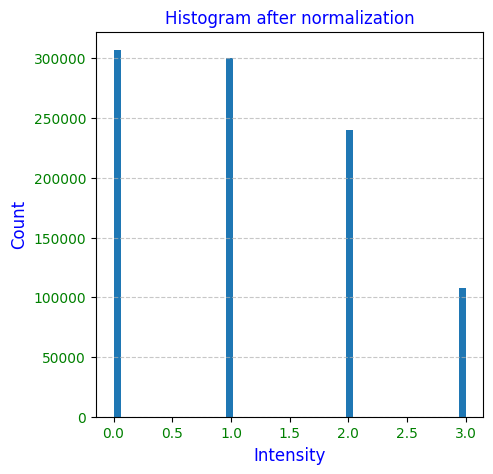

In [ ]:
# HISTOGRAM
plt.figure(figsize=(5, 5))
plt.hist(labels_img.ravel(), bins=50)
plt.title("Histogram after normalization", fontsize=12, color='blue')
plt.xlabel("Intensity", fontsize=12, color='blue')
plt.ylabel("Count", fontsize=12, color='blue')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(fontsize=10, color='green')
plt.yticks(fontsize=10, color='green')
plt.show()

### Watershed Segmentation for Outskirts of New Delhi

This section applies the watershed algorithm to segment the SAR imagery of the outskirts of New Delhi into distinct regions using the gradient magnitude and predefined markers. The watershed algorithm refines the segmentation by considering the gradient information, resulting in more accurate boundaries between regions. The output is visualized as a color-coded segmentation map.

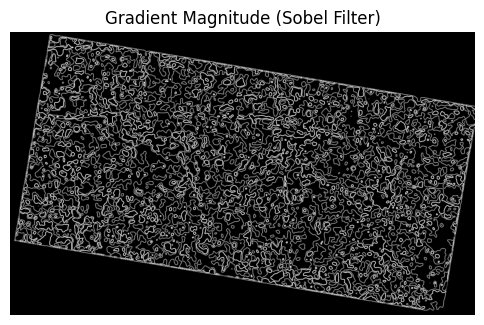

In [ ]:
# Compute the gradient magnitude using the Sobel filter
gradient_magnitude = sobel(labels_img)

# Display the gradient magnitude
plt.figure(figsize=(6, 6))
plt.imshow(gradient_magnitude, cmap='gray')
plt.title('Gradient Magnitude (Sobel Filter)')
plt.axis('off')
plt.show()

### Classification of Regions for Outskirts of New Delhi

This section classifies the segmented regions into urban, suburban, and rural classes based on their mean intensity and area. The classification is performed using predefined thresholds, and the results are visualized as a color-coded segmentation map. Additionally, the mean area and mean intensity of the classified regions are calculated and displayed.

Mean area of classified regions: 216121.0
Mean intensity of classified regions: -7.840126037597656


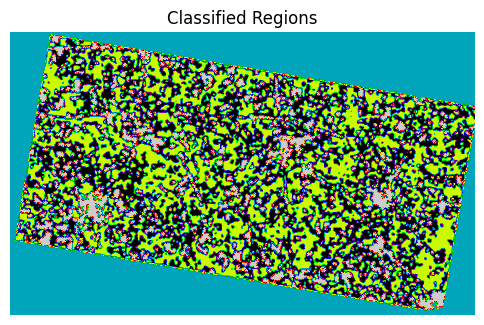

In [ ]:
# Classify the regions based on mean intensity and area
records = []
for reg in regionprops(labels_img, intensity_image=band_vv_new):
    # Calculate mean intensity and area for each region
    records.append({
        'label': reg.label,
        'mean_intensity': reg.mean_intensity,
        'area': reg.area
    })
df = pd.DataFrame(records)
# Define thresholds heuristically:
df['class'] = pd.cut(df['mean_intensity'],
                    bins=[-np.inf, (p5+p50)/2, (p50+p95)/2, np.inf],
                    labels=['rural','suburban','urban'])


mean_area = df['area'].mean()
print(f'Mean area of classified regions: {mean_area}')


mean_intensity = df['mean_intensity'].mean()
print(f'Mean intensity of classified regions: {mean_intensity}')



# Display the classified regions
plt.figure(figsize=(6, 6))
plt.imshow(labels_img, cmap='nipy_spectral')
plt.title('Classified Regions')
plt.axis('off')
plt.show()

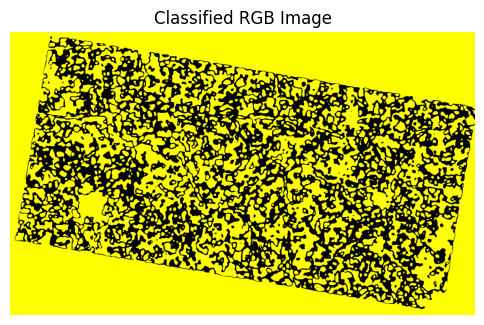

In [ ]:
# Initialize RGB canvas
h, w = band_vv_new.shape
rgb = np.zeros((h, w, 3), dtype=np.uint8)
# Color map with RGB values
color_dict = {'urban': [255, 0, 0], 'suburban': [0, 255, 0], 'rural': [255, 255, 0]}

for _, row in df.iterrows():
    # Create a mask for the current label
    mask = labels_img == row['label']
    rgb[mask] = color_dict[row['class']]
# Display the RGB image
plt.figure(figsize=(6,6))
plt.imshow(rgb)
plt.title('Classified RGB Image')
plt.axis('off')
plt.show()

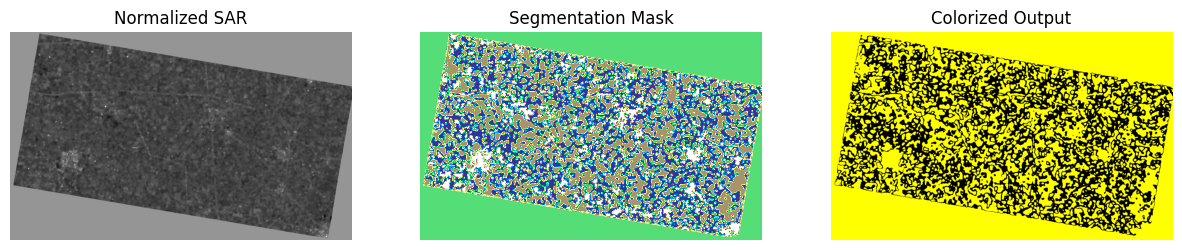

In [ ]:
# Plot the original image, segmentation mask, and colorized output
fig, axes = plt.subplots(1,3, figsize=(15,5))
axes[0].imshow(band_vv_new, cmap='gray'); axes[0].set_title('Normalized SAR')
axes[1].imshow(labels_img, cmap='terrain'); axes[1].set_title('Segmentation Mask')
axes[2].imshow(rgb); axes[2].set_title('Colorized Output')
for ax in axes: ax.axis('off')
plt.show()

In [ ]:
#Area percentage of each class
total = h*w
area_pct_2 = df.groupby('class')['area'].sum() / total * 100
print(area_pct_2)

class
rural       67.871798
suburban     0.000000
urban        0.000000
Name: area, dtype: float64


In [ ]:
# Percentiles for the histogram
# 5% = rural, 50% = suburban, 95% = urban
p5, p50, p95 = np.percentile(labels_img, [5, 50, 95])

print(f"Seeds at: 5%={p5:.3f}, 50%={p50:.3f}, 95%={p95:.3f}")

# Create markers for watershed segmentation
markers[labels_img <= p5]                       = 1   # definitely rural
markers[(labels_img >  p5)  & (labels_img <= p50)]  = 2   # suburban
markers[(labels_img >  p50) & (labels_img <= p95)]  = 3   # urban
markers[labels_img >   p95]                      = 4   # very dense urban

# Calculate area percentages
total_area = labels_img.size
area_percentage = {
    'rural': np.sum(markers == 1) / total_area * 100,
    'suburban': np.sum(markers == 2) / total_area * 100,
    'urban': np.sum(markers == 3) / total_area * 100,
    'very_dense_urban': np.sum(markers == 4) / total_area * 100
}

Seeds at: 5%=0.000, 50%=1.000, 95%=3.000


### Percentage of Urban Area

This section calculates and displays the percentage of urban area, including rural, suburban, urban, and very dense urban regions, based on the classified segmentation. The results are presented as both textual output and a bar chart for better visualization.

In [ ]:
for key, value in area_percentage.items():
    print(f"{key.capitalize()}: {value:.2f}%")

Rural: 32.13%
Suburban: 31.47%
Urban: 36.40%
Very_dense_urban: 0.00%


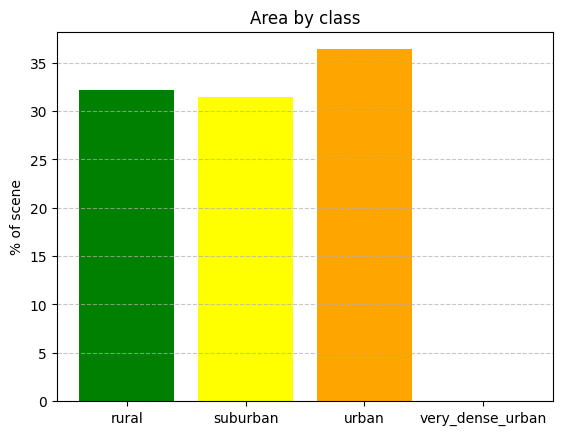

In [ ]:
# Plot the area percentages as a bar chart
plt.bar(area_percentage.keys(), area_percentage.values(), color=['green', 'yellow', 'orange', 'red'])

# Add labels and title to the plot
plt.ylabel('% of scene')
plt.title('Area by class')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()